In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import urllib.request
import zipfile
import numpy as np
from IPython.display import Image

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

## STEP 1. Load Dataset

### 어린이,노인남녀,일반남녀 Mel_Spec 이미지로 구성


In [ ]:
base = tf.io.gfile.glob(str('/content/drive/MyDrive/ColabNotebooks/Age_estimation_dataset') + '/*/*/*')
base = tf.random.shuffle(base)
num_samples = len(base)
print('Number of total train examples:', num_samples)

Number of total train examples: 29999


## STEP 2. 전처리 (ImageDataGenerator)

In [3]:
train_dir = '/content/drive/MyDrive/ColabNotebooks/Age_estimation_dataset/train'
valid_dir = '/content/drive/MyDrive/ColabNotebooks/Age_estimation_dataset/validation'
test_dir = '/content/drive/MyDrive/ColabNotebooks/Age_estimation_dataset/test'

In [4]:
training_datagen = ImageDataGenerator(
    rescale=1. / 255,
    # 위의 옵션 값들을 보고 적절히 대입하여 줍니다.
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
    )

### Training_generator / Validation_generator / Test_generator

In [5]:
training_generator = training_datagen.flow_from_directory(train_dir, 
                                                          batch_size=128,
                                                          target_size=(224,224),
                                                          class_mode='categorical',
                                                          subset='training'
                                                         )

Found 14400 images belonging to 3 classes.


In [6]:
validation_generator = training_datagen.flow_from_directory(valid_dir, 
                                                          batch_size=128,
                                                          target_size=(224,224),
                                                          class_mode='categorical',
                                                          subset='training'
                                                         )

Found 4800 images belonging to 3 classes.


In [7]:
test_generator = training_datagen.flow_from_directory(test_dir, 
                                                          batch_size=128,
                                                          target_size=(224,224),
                                                          class_mode='categorical',
                                                          subset='training'
                                                         )

Found 4800 images belonging to 3 classes.


## STEP 3. 시각화

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
class_map = {
    0: '노인남녀',
    1: '어린이',
    2: '일반남녀'
}

In [ ]:
base_dir = '/content/drive/MyDrive/ColabNotebooks/Age estimation dataset'

In [ ]:
original_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
original_generator = original_datagen.flow_from_directory(base_dir,
                                                          batch_size=128,
                                                          target_size=(224,224),
                                                          class_mode='categorical'
                                                          )

Found 2935 images belonging to 2 classes.


오리지널 사진 파일
(128, 150, 150, 3) (128, 2)
[1. 0.]


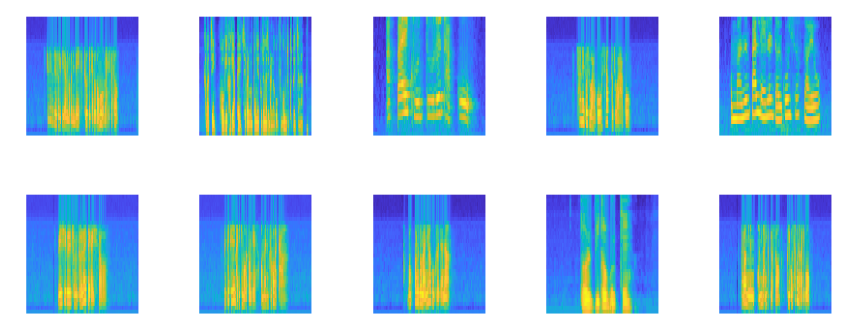

Augmentation 적용한 사진 파일
(128, 150, 150, 3) (128, 3)
[1. 0. 0.]


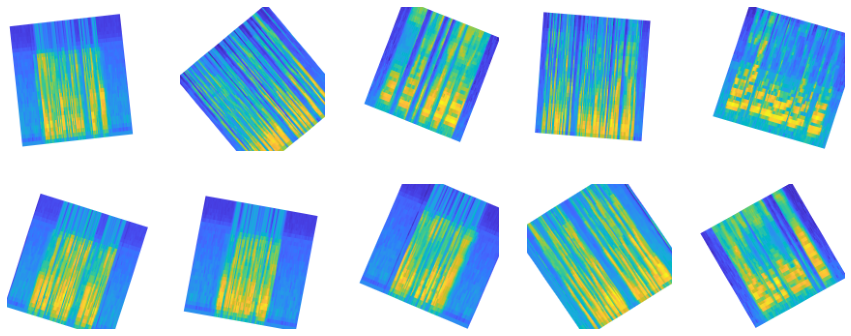

In [ ]:
print('오리지널 사진 파일')

for x,y in original_generator:
  print(x.shape, y.shape)
  print(y[0])

  fig, axes = plt.subplots(2,5)
  fig.set_size_inches(15, 6)
  for i in range(10):
    axes[i//5, i%5].imshow(x[i])
    #axes[i//5, i%5].set_title(class_map[int(y[i])], fontsize=15)
    axes[i//5, i%5].axis('off')

  plt.show()
  break

print('Augmentation 적용한 사진 파일')

for x,y in training_generator:
  print(x.shape, y.shape)
  print(y[0])

  fig, axes = plt.subplots(2,5)
  fig.set_size_inches(15, 6)
  for i in range(10):
    axes[i//5, i%5].imshow(x[i])
    #axes[i//5, i%5].set_title(class_map[int(y[i])], fontsize=15)
    axes[i//5, i%5].axis('off')

  plt.show()
  break

### Conv2d 거친 후 이미지 시각화해보기

In [ ]:
for x, y in original_generator:
  pic = x[:5]
  break
pic.shape

(5, 150, 150, 3)

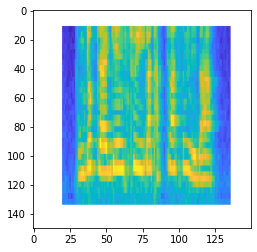

In [ ]:
#시각화 해보기
plt.imshow(pic[0])

In [ ]:
conv2d = Conv2D(64, (3, 3), input_shape=(150, 150, 3))
conv2d_activation = Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3))

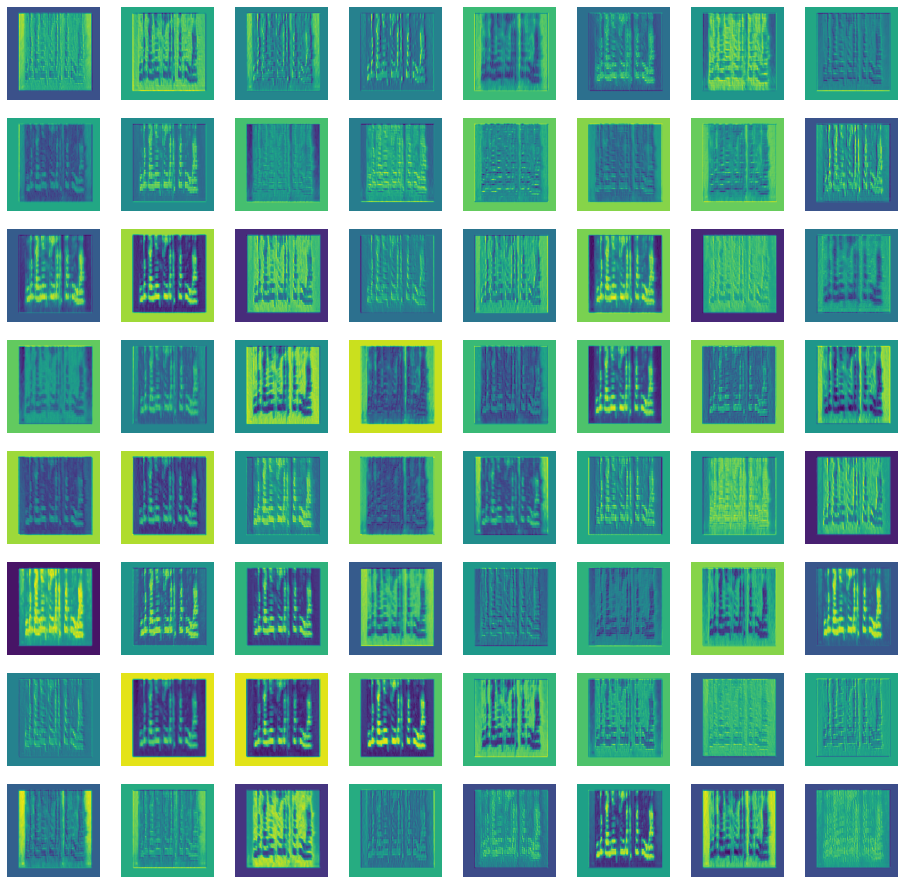

In [ ]:
fig, axes = plt.subplots(8,8)
fig.set_size_inches(16, 16)
for i in range(64):
  axes[i//8, i%8].imshow(conv2d(pic)[0,:,:,i])
  axes[i//8, i%8].axis('off')

## STEP 3. 모델 정의 (Sequential)

In [8]:
model = Sequential([
    # Conv2D, MaxPooling2D 조합으로 층을 쌓습니다. 첫번째 입력층의 input_shape은 (150, 150, 3)으로 지정합니다.
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2), 
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    # 2D -> 1D로 변환을 위하여 Flatten 합니다.
    Flatten(),
    # 과적합 방지를 위하여 Dropout을 적용합니다.
    Dropout(0.5),
    # Dense
    Dense(512, activation='relu'),
    # Classification을 위한 Softmax 
    # 출력층의 갯수는 클래스의 갯수와 동일하게 맞춰줍니다 (3개)
    Dense(3, activation='softmax'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        3

## STEP 4. 컴파일 (compile)

In [9]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

## STEP 5. ModelCheckpoint

`val_loss` 기준으로 epoch 마다 최적의 모델을 저장하기 위하여, ModelCheckpoint를 만듭니다.
* `checkpoint_path`는 모델이 저장될 파일 명을 설정합니다.
* `ModelCheckpoint`을 선언하고, 적절한 옵션 값을 지정합니다.

In [10]:
checkpoint_path = "rms2_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

## STEP 6. 학습 (fit)

In [12]:
epochs=20
history = model.fit(training_generator,
                    validation_data=(validation_generator),
                    epochs=epochs,
                    callbacks=[checkpoint]
                    )

Epoch 1/20
113/113 [==============================] - 5577s 49s/step - loss: 0.8708 - acc: 0.6237 - val_loss: 0.8216 - val_acc: 0.6548

Epoch 00001: val_loss improved from inf to 0.82164, saving model to rms2_checkpoint.ckpt
Epoch 2/20
113/113 [==============================] - 368s 3s/step - loss: 0.3663 - acc: 0.8553 - val_loss: 0.7380 - val_acc: 0.6923

Epoch 00002: val_loss improved from 0.82164 to 0.73799, saving model to rms2_checkpoint.ckpt
Epoch 3/20
113/113 [==============================] - 365s 3s/step - loss: 0.2309 - acc: 0.9181 - val_loss: 0.7694 - val_acc: 0.7523

Epoch 00003: val_loss did not improve from 0.73799
Epoch 4/20
113/113 [==============================] - 364s 3s/step - loss: 0.1613 - acc: 0.9419 - val_loss: 1.1468 - val_acc: 0.7171

Epoch 00004: val_loss did not improve from 0.73799
Epoch 5/20
113/113 [==============================] - 367s 3s/step - loss: 0.1259 - acc: 0.9542 - val_loss: 0.6424 - val_acc: 0.7931

Epoch 00005: val_loss improved from 0.73799 

## STEP 7. 학습 완료 후 Load Weights (ModelCheckpoint)

In [13]:
model.load_weights(checkpoint_path)

In [14]:
model.save('/content/drive/MyDrive/ColabNotebooks/무곤스 몰래 만드는 폴더/BroadCnS/rmsprop2_idg.h5')

In [15]:
model.evaluate(validation_generator)

38/38 [==============================] - 93s 2s/step - loss: 0.4285 - acc: 0.8919


[0.4284960925579071, 0.8918750286102295]

In [16]:
model.evaluate(test_generator)

38/38 [==============================] - 1476s 40s/step - loss: 8.6990 - acc: 0.3346


[8.699027061462402, 0.3345833420753479]

In [17]:
import matplotlib.pyplot as plt

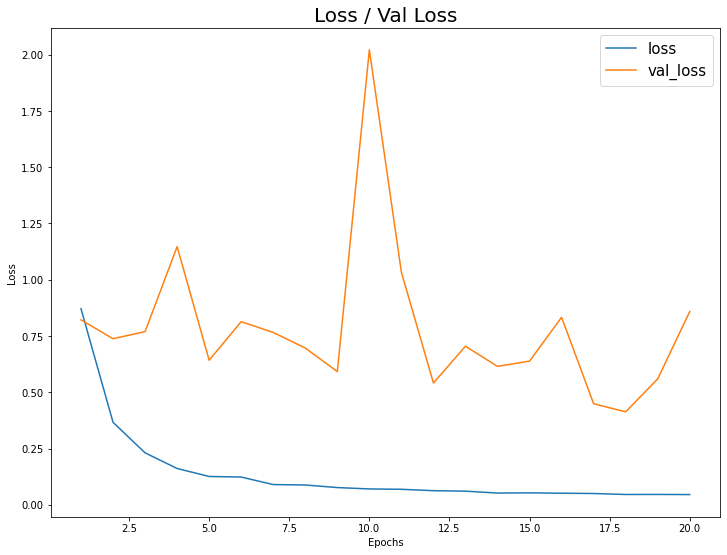

In [18]:
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, epochs+1), history.history['loss'])
plt.plot(np.arange(1, epochs+1), history.history['val_loss'])
plt.title('Loss / Val Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'], fontsize=15)
plt.show()

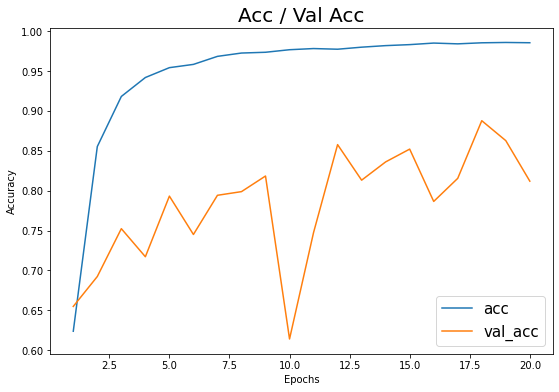

In [19]:
plt.figure(figsize=(9, 6))
plt.plot(np.arange(1, epochs+1), history.history['acc'])
plt.plot(np.arange(1, epochs+1), history.history['val_acc'])
plt.title('Acc / Val Acc', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['acc', 'val_acc'], fontsize=15)
plt.show()